In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spst

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Initialization and Data Loading

In [2]:
# Loading Data

data=pd.read_csv("/content/drive/MyDrive/DDDM_Project/Data/final_dataset.csv")
df =data.copy().drop(columns=["Unnamed: 0"])

# cleaning

df["Month"] = pd.to_datetime(df["Month"])

# Sort by time then ETF (important for sanity and reproducibility)
df = df.sort_values(["Month", "ETF"]).reset_index(drop=True)

# Ensure tag columns are integers (0/1)
TAG_COLS = [
    "is_equity",
    "is_international",
    "is_gov",
    "is_credit",
    "is_macro"
]

for c in TAG_COLS:
    df[c] = df[c].astype(int)

df.head()

,Month,Open,Close,Growth,ETF,rf_month,outperformed,excess_return,months_outperforming,TB3MS_lag1,...,inflation_yoy_lag1,inflation_shock_lag1,yield_slope_lag1,credit_spread_lag1,VIXCLS_lag1,is_equity,is_international,is_gov,is_credit,is_macro
0,1993-01-31,43.96875,43.93750,-0.000711,SPY,0.002466,0,-0.003177,0,3.22,...,0.029667,-0.001032,3.550000,2.040000,12.191364,1,0,0,0,0
1,1993-02-28,43.96875,44.40625,0.009950,SPY,0.002409,1,0.007541,0,3.00,...,0.032538,0.000842,3.600000,2.070000,12.409000,1,0,0,0,0
2,1993-03-31,44.56250,45.18750,0.014025,SPY,0.002426,1,0.011600,1,2.93,...,0.032468,-0.000566,3.328947,2.131053,13.721579,1,0,0,0,0
3,1993-04-30,45.25000,44.03125,-0.026934,SPY,0.002361,0,-0.029294,2,2.95,...,0.030194,-0.001085,3.025217,2.174783,13.606087,1,0,0,0,0
4,1993-05-31,44.09375,45.21875,0.025514,SPY,0.002434,1,0.023080,0,2.87,...,0.031564,0.000896,3.099524,2.170476,12.840952,1,0,0,0,0


In [3]:
# validate data

def validate_panel(df):
    # Required columns
    required_cols = [
        "Month", "ETF",
        "excess_return", "outperformed", "rf_month"
    ] + TAG_COLS

    missing = set(required_cols) - set(df.columns)
    assert len(missing) == 0, f"Missing columns: {missing}"

    # One row per (Month, ETF)
    dupes = df.duplicated(subset=["Month", "ETF"])
    assert not dupes.any(), "Duplicate (Month, ETF) rows detected"

    # Month sorted
    assert df["Month"].is_monotonic_increasing, "Month not sorted"

    # No NaNs in required fields
    nan_cols = df[required_cols].columns[df[required_cols].isna().any()]
    assert len(nan_cols) == 0, f"NaNs found in columns: {list(nan_cols)}"

    # Tags must be 0/1
    for c in TAG_COLS:
        bad = ~df[c].isin([0, 1])
        assert not bad.any(), f"Invalid values in tag column {c}"

    # outperformed must be binary
    assert df["outperformed"].isin([0, 1]).all(), "outperformed not binary"

    # all ETFs must have a tag
    tag_sums = (
        df.groupby("ETF")[TAG_COLS]
          .sum()
          .sum(axis=1)
    )

    no_tag_etfs = tag_sums[tag_sums == 0].index.tolist()

    assert len(no_tag_etfs) == 0, (
        f"ETFs with no active tags detected: {no_tag_etfs}"
    )

    print("✅ Panel validation passed")

In [4]:
validate_panel(df)

✅ Panel validation passed


In [5]:
# Configuring Constants

# (TAG_COLS, MACRO_COLS)
# (ESS_B, alpha0, beta0, eps_B)
# (nu, var_window, mc_N, eps_s, tau0)

TAG_COLS = [
    "is_equity",
    "is_international",
    "is_gov",
    "is_credit",
    "is_macro",
]

MACRO_COLS = [
    "TB3MS_lag1",
    "dTB3MS_lag1",
    "UNRATE_lag1",
    "inflation_yoy_lag1",
    "inflation_shock_lag1",
    "yield_slope_lag1",
    "credit_spread_lag1",
    "VIXCLS_lag1",
]

MONTH_COL = "Month"
ETF_COL   = "ETF"

GROWTH_COL = "Growth"         # actual ETF return for accounting
RET_COL   = "excess_return"   # continuous excess return x_{i,t}
BIN_COL   = "outperformed"    # binary 1{x_{i,t} > 0}
RF_COL    = "rf_month"        # monthly risk-free rate

# bernoulli params
ESS_B = 10
alpha0, beta0 = 2.0, 2.0
epsilon_B = 1e-8

# student-t params
nu = 5
vol_window = 12
mc_N = 2000
eps_s = 0.0005
tau0 = 0.05

# rng for reproducability
seed = 123
rng = np.random.default_rng(seed)

In [6]:
MONTH_COL = "Month"  # whatever yours is
df[MONTH_COL] = pd.to_datetime(df[MONTH_COL])

split_date = pd.Timestamp("2014-12-31")
df_train = df[df[MONTH_COL] <= split_date].copy()
df_test  = df[df[MONTH_COL] >  split_date].copy()

Z_COLS = MACRO_COLS          # your lagged macro columns
USE_INTERCEPT = True

def make_z_vec_from_df(df_t):
    """
    Build z_t (context vector) from the decision-month dataframe df_t.
    Assumes macro columns are constant within month; takes the first row.
    Returns shape (d,).
    """
    row0 = df_t.iloc[0]
    z = row0[Z_COLS].astype(float).values
    if USE_INTERCEPT:
        z = np.concatenate(([1.0], z))
    return z

In [7]:
Z_mean = df_train[Z_COLS].mean()
Z_std  = df_train[Z_COLS].std(ddof=0).replace(0.0, 1.0)  # avoid divide-by-zero

def apply_zscore(df_in):
    df_out = df_in.copy()
    df_out[Z_COLS] = (df_out[Z_COLS] - Z_mean) / Z_std
    return df_out

df_train = apply_zscore(df_train)
df_test  = apply_zscore(df_test)

# (Optional) also create a standardized full df for full-sample descriptive plots
df_std = apply_zscore(df)

## Results tracking

In [8]:
WEALTH_LOG_COLS = [
    "Month_hold",      # holding month (t+1)
    "port_ret",        # realized portfolio return in Month_hold
    "wealth",          # wealth after applying port_ret
    "w_cash",          # cash weight held in Month_hold
    "W_etf",           # total ETF exposure held in Month_hold (1 - w_cash)
    "mean_score",      # mean of scores over available ETFs at decision month t
    "turnover",        # 0.5 * sum_j |w_j(t+1) - w_j(t)| (including CASH)
    "n_bet",           # number of ETFs with weight > 0 in Month_hold
    "top5_share",      # sum of top-5 ETF weights in Month_hold (ETFs only)
]

WEIGHTS_LOG_COLS = [
    "Month_hold",      # holding month (t+1)
    "ETF",             # ETF ticker or "CASH"
    "weight",          # portfolio weight held in Month_hold
]

SCORES_LOG_COLS = [
    "Month_decide",    # decision month (t)
    "ETF",             # ETF ticker
    "score",           # nonnegative score produced at decision month t
]


## Portfolio Policy (shared)

In [9]:
def scores_to_weights(scores, k, eps=1e-16):
    """
    Convert nonnegative ETF scores at decision month t into portfolio weights to HOLD at month t+1.

    Inputs
    ------
    scores : dict[str -> float]
        Nonnegative scores s_{i,t} for ETFs available at decision month t.
    k : float
        Exposure strength parameter.
    eps : float
        Tiny constant to avoid division-by-zero in normalization.

    Outputs
    -------
    w_etf : dict[str -> float]
        ETF weights for holding month (t+1). Sums to W_etf.
    w_cash : float
        Cash weight for holding month (t+1). Equals 1 - W_etf.
    diag : dict
        Diagnostics: mean_score (S_t), W_etf, n_pos_scores, top5_share.
    """
    if scores is None or len(scores) == 0:
        # No arms available: full cash
        return {}, 1.0, {"mean_score": 0.0, "W_etf": 0.0, "n_pos_scores": 0, "top5_share": 0.0}

    # Ensure nonnegative floats (defensive)
    s = {etf: float(max(0.0, v)) for etf, v in scores.items()}
    vals = np.fromiter(s.values(), dtype=float)

    mean_score = float(vals.mean()) if len(vals) else 0.0
    n_pos = int((vals > 0).sum())

    # If no signal, go full cash
    if n_pos == 0 or mean_score <= 0.0:
        return {}, 1.0, {"mean_score": mean_score, "W_etf": 0.0, "n_pos_scores": 0, "top5_share": 0.0}

    # Total ETF exposure W_etf from mean score and k:
    # W_etf = (k * mean_score) / (1 + k * mean_score)
    # (Always in (0,1), increases with k and mean_score)
    W_etf = (k * mean_score) / (1.0 + k * mean_score) if k > 0 else 0.0
    W_etf = float(np.clip(W_etf, 0.0, 1.0))
    w_cash = 1.0 - W_etf

    # Within-ETF proportions: linear normalization over positive scores
    pos_sum = float(vals[vals > 0].sum())
    if pos_sum <= eps:
        # numerical fallback -> full cash
        return {}, 1.0, {"mean_score": mean_score, "W_etf": 0.0, "n_pos_scores": 0, "top5_share": 0.0}

    w_etf = {etf: W_etf * (v / pos_sum) for etf, v in s.items() if v > 0}

    # Concentration metric: top-5 share among ETF weights
    if len(w_etf) == 0:
        top5_share = 0.0
    else:
        top5_share = float(np.sum(sorted(w_etf.values(), reverse=True)[:5]))

    diag = {
        "mean_score": mean_score,
        "W_etf": W_etf,
        "n_pos_scores": len(w_etf),
        "top5_share": top5_share,
    }
    return w_etf, w_cash, diag

In [10]:
def turnover(prev_weights_full, curr_weights_full):
    """
    0.5 * sum_j |w_j(new) - w_j(old)| over union of keys.
    Both dicts should include CASH explicitly.
    """
    keys = set(prev_weights_full) | set(curr_weights_full)
    return 0.5 * sum(abs(curr_weights_full.get(k, 0.0) - prev_weights_full.get(k, 0.0)) for k in keys)

## Accounting

In [11]:
def portfolio_return_for_month(df_hold, w_etf, w_cash):
    """
    Realized TOTAL portfolio return in a holding month (t+1):

        r_p = sum_i w_i * Growth_{i,t+1} + w_cash * rf_{t+1}

    Uses:
    - Growth for ETF returns (actual traded returns)
    - rf_month for cash return
    """

    # rf is unique per month
    rf_vals = df_hold[RF_COL].dropna().unique()
    assert len(rf_vals) == 1, f"Expected exactly one rf value, got {rf_vals}"
    rf = float(rf_vals[0])

    # realized ETF returns (Growth)
    realized_growth = dict(
        zip(df_hold[ETF_COL].values, df_hold[GROWTH_COL].values)
    )

    etf_ret = 0.0
    for etf, w in w_etf.items():
        etf_ret += float(w) * float(realized_growth.get(etf, 0.0))

    cash_ret = float(w_cash) * rf
    return etf_ret + cash_ret

## Student-t Beliefs and Scoring

In [12]:
# STUDENT-t: GLOBAL VOLATILITY s_t (trailing)


def global_volatility(df, month_t, vol_window=vol_window):
    """
    Compute global volatility estimate s_t using trailing months strictly before month_t.
    Uses cross-sectional ETF excess returns (RET_COL) pooled.
    """
    months = sorted(df[MONTH_COL].unique())
    t_idx = months.index(month_t)

    # Need at least vol_window months before t
    if t_idx < vol_window:
        return np.nan

    trailing_months = months[t_idx - vol_window : t_idx]  # strictly before t
    x = df.loc[df[MONTH_COL].isin(trailing_months), RET_COL].astype(float).values

    # Use sample std; floor to avoid zeros
    s = float(np.nanstd(x, ddof=1))
    return max(s, 1e-8)

In [13]:
# STUDENT-t: TAG-BELIEF LAYER (birth mean only)

def init_belief_state_studentt():
    """
    Track global + per-tag mean of excess_return for birth prior mean initialization.
    Stores counts and sums.
    """
    return {
        "global_n": 0,
        "global_sum": 0.0,
        "tag_n": {tag: 0 for tag in TAG_COLS},
        "tag_sum": {tag: 0.0 for tag in TAG_COLS},
    }

def update_beliefs_studentt(belief_state, df_t):
    """
    Update global + per-tag running sums for excess_return using full info in df_t.
    """
    x = df_t[RET_COL].astype(float).values
    belief_state["global_n"] += int(len(x))
    belief_state["global_sum"] += float(np.nansum(x))

    tags_mat = df_t[TAG_COLS].astype(int).values
    for j, tag in enumerate(TAG_COLS):
        mask = tags_mat[:, j] == 1
        if mask.any():
            x_k = x[mask]
            belief_state["tag_n"][tag] += int(len(x_k))
            belief_state["tag_sum"][tag] += float(np.nansum(x_k))

def studentt_birth_prior_mean(belief_state, tags_row):
    """
    Mean-only birth prior using additive tag deviations:
      m_i = m_g + sum_{tag present} (m_tag - m_g)
    with safe fallbacks when counts are small.
    """
    n_g = belief_state["global_n"]
    m_g = belief_state["global_sum"] / n_g if n_g > 0 else 0.0

    m = float(m_g)
    for tag in TAG_COLS:
        if int(tags_row[tag]) == 1:
            n_k = belief_state["tag_n"][tag]
            m_k = belief_state["tag_sum"][tag] / n_k if n_k > 0 else m_g
            m += float(m_k - m_g)
    return float(m)

Non-contextual scoring and ETF beliefs

In [14]:
# STUDENT-t: TAG-BELIEF LAYER (birth mean only)

def init_states_studentt():
    """
    Per-ETF state stores posterior over mean mu_i:
      states[ETF] = {"m": posterior_mean, "v": posterior_var}
    """
    return {}

def ensure_states_studentt(states, belief_state, df_t):
    """
    Initialize any new ETF with prior mean from tags and prior var tau0^2.
    """
    first_rows = df_t.drop_duplicates(subset=[ETF_COL])
    for _, row in first_rows.iterrows():
        etf = row[ETF_COL]
        if etf not in states:
            m0 = studentt_birth_prior_mean(belief_state, row)
            states[etf] = {"m": float(m0), "v": float(tau0**2)}

def update_states_studentt(states, df_t, s_t):
    """
    Update posterior over mu_i given observation x_it and noise variance s_t^2.
    """
    if not np.isfinite(s_t) or s_t <= 0:
        return  # skip updates if s_t undefined early sample

    obs_var = float(s_t**2)

    for _, row in df_t.iterrows():
        etf = row[ETF_COL]
        x = float(row[RET_COL])

        m_prev = states[etf]["m"]
        v_prev = states[etf]["v"]

        # Normal-Normal update
        v_post = 1.0 / (1.0 / v_prev + 1.0 / obs_var)
        m_post = v_post * (m_prev / v_prev + x / obs_var)

        states[etf]["m"] = float(m_post)
        states[etf]["v"] = float(v_post)

In [15]:
def scores_studentt_v2(states, A_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng):
    """
    V2: risk-adjusted upside score
      score = E[max(X,0)] / s_t
    where X = mu_i + s_t * T_nu
    """
    scores = {}
    if (not np.isfinite(s_t)) or s_t <= 0:
        return {etf: 0.0 for etf in A_t}

    t_draws = spst.t.rvs(df=nu, size=mc_N, random_state=rng).astype(float)
    denom = float(max(s_t, 1e-12))

    for etf in A_t:
        st = states.get(etf, None)
        if st is None:
            scores[etf] = 0.0
            continue

        mu = float(st["m"])
        X = mu + float(s_t) * t_draws
        upside = float(np.mean(np.maximum(X, 0.0)))
        score = upside / denom

        scores[etf] = max(0.0, max(score, float(eps_s)) if score > 0 else 0.0)

    return scores

In [16]:
def scores_studentt_v3_topN(states, A_t, s_t, N=50, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng):
    """
    Student-t score V3:
      1) compute risk-adjusted scores via V2
      2) keep only Top-N ETFs by score (others set to 0)
    """
    base_scores = scores_studentt_v2(
        states, A_t, s_t,
        nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
    )

    # sort ETFs by score descending
    ranked = sorted(base_scores.items(), key=lambda kv: kv[1], reverse=True)

    # keep only positive-score ETFs, then top N among them
    ranked_pos = [(etf, s) for etf, s in ranked if s > 0.0]
    keep = set(etf for etf, _ in ranked_pos[:int(N)])

    # zero out everyone else
    scores = {etf: (base_scores[etf] if etf in keep else 0.0) for etf in A_t}
    return scores


Contextual student-t ETF states


In [17]:
# STUDENT-t: ETF STATES (posterior over mean)


def init_states_studentt_contextual():
    """
    Per-ETF state stores posterior over beta_i:
      states[ETF] = {"m": (d,), "V": (d,d)}
    """
    return {}

def ensure_states_studentt_contextual(states, belief_state, df_t, d):
    """
    Initialize new ETFs with:
      beta ~ N(m0, V0)

    We use tags ONLY to initialize the intercept prior mean (baseline alpha),
    leaving macro slopes at 0 initially (conservative, interpretable).
    """
    first_rows = df_t.drop_duplicates(subset=[ETF_COL])
    for _, row in first_rows.iterrows():
        etf = row[ETF_COL]
        if etf in states:
            continue

        # prior mean vector
        m0 = np.zeros(d, dtype=float)

        # tags set only intercept prior mean
        intercept_prior = float(studentt_birth_prior_mean(belief_state, row))
        if USE_INTERCEPT:
            m0[0] = intercept_prior
        else:
            # if no intercept, you can choose to put this into the first macro coeff or just drop it
            pass

        # prior covariance (ridge-like)
        V0 = (tau0**2) * np.eye(d, dtype=float)

        states[etf] = {"m": m0, "V": V0}

def update_states_studentt_contextual(states, df_t, z_t, s_t):
    """
    Bayesian linear regression update per ETF:
      prior: beta ~ N(m, V)
      likelihood: x | beta ~ N(z^T beta, s_t^2)

    Posterior:
      V_post = (V^-1 + (1/s^2) z z^T)^-1
      m_post = V_post (V^-1 m + (1/s^2) z x)
    """
    if not np.isfinite(s_t) or s_t <= 0:
        return

    s2 = float(s_t**2)
    z = np.asarray(z_t, dtype=float).reshape(-1, 1)  # (d,1)

    for _, row in df_t.iterrows():
        etf = row[ETF_COL]
        x = float(row[RET_COL])

        m = states[etf]["m"].reshape(-1, 1)           # (d,1)
        V = states[etf]["V"]                          # (d,d)

        # Use a numerically stable “information form” update
        Vinv = np.linalg.inv(V)
        Vinv_post = Vinv + (1.0 / s2) * (z @ z.T)
        V_post = np.linalg.inv(Vinv_post)

        m_post = V_post @ (Vinv @ m + (1.0 / s2) * z * x)

        states[etf]["m"] = m_post.ravel()
        states[etf]["V"] = V_post

In [18]:
def scores_studentt_contextual_v2_predvar(states, A_t, z_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng):
    """
    Contextual Student-t score with predictive variance:
      mu_hat = z^T m_beta
      scale = sqrt(s_t^2 + z^T V_beta z)
      X = mu_hat + scale * T_nu
      score = E[max(X,0)] / scale
    """
    if (not np.isfinite(s_t)) or s_t <= 0:
        return {etf: 0.0 for etf in A_t}

    z = np.asarray(z_t, dtype=float).reshape(-1, 1)  # (d,1)
    t_draws = spst.t.rvs(df=nu, size=mc_N, random_state=rng).astype(float)

    scores = {}
    for etf in A_t:
        st = states.get(etf, None)
        if st is None:
            scores[etf] = 0.0
            continue

        m = np.asarray(st["m"], dtype=float).reshape(-1, 1)
        V = np.asarray(st["V"], dtype=float)

        mu_hat = float((z.T @ m)[0, 0])
        var_beta = float((z.T @ V @ z)[0, 0])

        scale = float(np.sqrt(max(s_t**2 + var_beta, 1e-12)))
        X = mu_hat + scale * t_draws

        upside = float(np.mean(np.maximum(X, 0.0)))
        score = upside / scale

        scores[etf] = max(0.0, max(score, float(eps_s)) if score > 0 else 0.0)

    return scores

In [19]:
def scores_studentt_contextual_v2_predvar_topN(
    states, A_t, z_t, s_t, N=50, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
):
    """
    Contextual Student-t score (predvar) + Top-N selection:
      1) compute base contextual scores
      2) keep only Top-N ETFs by score (others set to 0)
    """
    base_scores = scores_studentt_contextual_v2_predvar(
        states, A_t, z_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
    )

    ranked = sorted(base_scores.items(), key=lambda kv: kv[1], reverse=True)
    ranked_pos = [(etf, s) for etf, s in ranked if s > 0.0]
    keep = set(etf for etf, _ in ranked_pos[:int(N)])

    return {etf: (base_scores[etf] if etf in keep else 0.0) for etf in A_t}


## Run Student-t Simulation

In [40]:
def run_policy_simulation_studentt_v3_topN_warm(
    df, k, N=10, initial_wealth=1000.0,
    belief_state_init=None,
    states_init=None
):
    """
    Non-contextual Student-t Top-N policy simulation with optional warm-start.
    Keeps chronology by creating a new wrapper function.

    Warm-start inputs:
      - belief_state_init: carried belief state (for birth priors)
      - states_init: carried per-ETF posterior states over mu_i
    """
    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)

    wealth_log = []
    weights_log = []
    scores_log = []

    belief_state = belief_state_init if belief_state_init is not None else init_belief_state_studentt()
    states = states_init if states_init is not None else init_states_studentt()

    prev_weights_full = {"CASH": 1.0}

    for t_idx in range(len(months) - 1):
        month_t = months[t_idx]
        month_hold = months[t_idx + 1]

        df_t = df[df[MONTH_COL] == month_t]
        df_hold = df[df[MONTH_COL] == month_hold]
        A_t = df_t[ETF_COL].unique().tolist()

        # learning at decision month t
        update_beliefs_studentt(belief_state, df_t)
        ensure_states_studentt(states, belief_state, df_t)

        s_t = global_volatility(df, month_t, vol_window=vol_window)
        update_states_studentt(states, df_t, s_t)

        # scoring (use your existing score function name here)
        # If your code uses scores_studentt_v2, swap this call accordingly.
        base_scores = scores_studentt_v2(states, A_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng)

        # Top-N filter
        ranked = sorted(base_scores.items(), key=lambda kv: kv[1], reverse=True)
        ranked_pos = [(etf, s) for etf, s in ranked if s > 0.0]
        keep = set(etf for etf, _ in ranked_pos[:int(N)])
        scores = {etf: (base_scores[etf] if etf in keep else 0.0) for etf in A_t}

        for etf, s in scores.items():
            scores_log.append({"Month_decide": month_t, "ETF": etf, "score": s})

        # policy weights for t+1
        w_etf, w_cash, diag = scores_to_weights(scores, k)

        for etf, w in w_etf.items():
            weights_log.append({"Month_hold": month_hold, "ETF": etf, "weight": w})
        weights_log.append({"Month_hold": month_hold, "ETF": "CASH", "weight": w_cash})

        # apply returns
        port_ret = portfolio_return_for_month(df_hold, w_etf, w_cash)
        wealth *= (1.0 + port_ret)

        curr_weights_full = {**w_etf, "CASH": w_cash}
        turn = turnover(prev_weights_full, curr_weights_full)
        prev_weights_full = curr_weights_full

        wealth_log.append({
            "Month_hold": month_hold,
            "port_ret": port_ret,
            "wealth": wealth,
            "w_cash": w_cash,
            "W_etf": 1.0 - w_cash,
            "mean_score": diag["mean_score"],
            "turnover": turn,
            "n_bet": diag["n_pos_scores"],
            "top5_share": diag["top5_share"],
        })

    return {
        "wealth": pd.DataFrame(wealth_log, columns=WEALTH_LOG_COLS),
        "weights": pd.DataFrame(weights_log, columns=WEIGHTS_LOG_COLS),
        "scores": pd.DataFrame(scores_log, columns=SCORES_LOG_COLS),
        "belief_state": belief_state,
        "states": states,
    }

In [21]:
def run_policy_simulation_studentt_contextual_topN(
    df, k, N=50, initial_wealth=1000.0,
    belief_state_init=None,
    states_init=None,
):
    """
    Contextual Student-t simulation + Top-N:
    - states are beta posteriors (m,V)
    - scoring uses contextual predvar score, then Top-N filter
    """
    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)

    wealth_log, weights_log, scores_log = [], [], []

    belief_state = belief_state_init if belief_state_init is not None else init_belief_state_studentt()
    states = states_init if states_init is not None else init_states_studentt_contextual()


    prev_weights_full = {"CASH": 1.0}

    for t_idx in range(len(months) - 1):
        month_t = months[t_idx]
        month_hold = months[t_idx + 1]

        df_t = df[df[MONTH_COL] == month_t]
        df_hold = df[df[MONTH_COL] == month_hold]
        A_t = df_t[ETF_COL].unique().tolist()

        z_t = make_z_vec_from_df(df_t)
        d = len(np.asarray(z_t).ravel())

        update_beliefs_studentt(belief_state, df_t)
        ensure_states_studentt_contextual(states, belief_state, df_t, d=d)

        s_t = global_volatility(df, month_t, vol_window=vol_window)
        update_states_studentt_contextual(states, df_t, z_t, s_t)

        # contextual predvar + Top-N
        scores = scores_studentt_contextual_v2_predvar_topN(
            states, A_t, z_t, s_t, N=N, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
        )

        for etf, s in scores.items():
            scores_log.append({"Month_decide": month_t, "ETF": etf, "score": s})

        w_etf, w_cash, diag = scores_to_weights(scores, k)

        for etf, w in w_etf.items():
            weights_log.append({"Month_hold": month_hold, "ETF": etf, "weight": w})
        weights_log.append({"Month_hold": month_hold, "ETF": "CASH", "weight": w_cash})

        port_ret = portfolio_return_for_month(df_hold, w_etf, w_cash)
        wealth *= (1.0 + port_ret)

        curr_weights_full = {**w_etf, "CASH": w_cash}
        turn = turnover(prev_weights_full, curr_weights_full)
        prev_weights_full = curr_weights_full

        wealth_log.append({
            "Month_hold": month_hold,
            "port_ret": port_ret,
            "wealth": wealth,
            "w_cash": w_cash,
            "W_etf": 1.0 - w_cash,
            "mean_score": diag["mean_score"],
            "turnover": turn,
            "n_bet": diag["n_pos_scores"],
            "top5_share": diag["top5_share"],
        })

    return {
        "wealth": pd.DataFrame(wealth_log, columns=WEALTH_LOG_COLS),
        "weights": pd.DataFrame(weights_log, columns=WEIGHTS_LOG_COLS),
        "scores": pd.DataFrame(scores_log, columns=SCORES_LOG_COLS),
        "belief_state": belief_state,
        "states": states,
    }
    return {"wealth": wealth_df, "weights": weights_df, "scores": scores_df}

## Gridsearching for k and N

In [22]:
k_grid = [25, 100, 200, 800]
N_grid = [5, 10, 20, 50, 100]

rows_train = []
res_ctx_train = {}   # store full TRAIN runs by (N, k)

# ---------- TRAIN GRID ----------
for N in N_grid:
    for k in k_grid:
        print(f"CTX Student-t Top-N TRAIN: N={N}, k={k}")

        res = run_policy_simulation_studentt_contextual_topN(
            df_train,
            k=k,
            N=N,
            initial_wealth=1000.0
        )

        res_ctx_train[(N, k)] = res
        w = res["wealth"]

        rows_train.append({
            "N": int(N),
            "k": float(k),
            "final_wealth": float(w["wealth"].iloc[-1]),
            "mean_W_etf": float(w["W_etf"].mean()),
            "mean_turnover": float(w["turnover"].mean()),
            "mean_top5_share": float(w["top5_share"].mean()),
            "mean_n_bet": float(w["n_bet"].mean()),
        })

summary_ctx_train = (
    pd.DataFrame(rows_train)
    .sort_values("final_wealth", ascending=False)
    .reset_index(drop=True)
)

summary_ctx_train

CTX Student-t Top-N TRAIN: N=5, k=25
CTX Student-t Top-N TRAIN: N=5, k=100
CTX Student-t Top-N TRAIN: N=5, k=200
CTX Student-t Top-N TRAIN: N=5, k=800
CTX Student-t Top-N TRAIN: N=10, k=25
CTX Student-t Top-N TRAIN: N=10, k=100
CTX Student-t Top-N TRAIN: N=10, k=200
CTX Student-t Top-N TRAIN: N=10, k=800
CTX Student-t Top-N TRAIN: N=20, k=25
CTX Student-t Top-N TRAIN: N=20, k=100
CTX Student-t Top-N TRAIN: N=20, k=200
CTX Student-t Top-N TRAIN: N=20, k=800
CTX Student-t Top-N TRAIN: N=50, k=25
CTX Student-t Top-N TRAIN: N=50, k=100
CTX Student-t Top-N TRAIN: N=50, k=200
CTX Student-t Top-N TRAIN: N=50, k=800
CTX Student-t Top-N TRAIN: N=100, k=25
CTX Student-t Top-N TRAIN: N=100, k=100
CTX Student-t Top-N TRAIN: N=100, k=200
CTX Student-t Top-N TRAIN: N=100, k=800


,N,k,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
0,5,800.0,5616.968684,0.928703,0.425704,0.928703,4.376426
1,5,200.0,5081.436965,0.864178,0.396024,0.864178,4.376426
2,10,800.0,5070.351142,0.939684,0.369255,0.608862,8.193916
3,10,200.0,4769.102443,0.899930,0.354047,0.586279,8.193916
4,5,100.0,4573.797076,0.797698,0.365294,0.797698,4.376426
5,20,800.0,4532.947097,0.945841,0.305178,0.443180,15.159696
6,10,100.0,4447.518804,0.854475,0.336959,0.560223,8.193916
7,20,200.0,4376.289026,0.921702,0.298083,0.434704,15.159696
8,20,100.0,4205.682700,0.891932,0.289698,0.424315,15.159696
9,50,800.0,3713.298454,0.949907,0.216189,0.340897,34.250951


In [23]:
best_ctx = (
    summary_ctx_train
    .sort_values(["final_wealth", "mean_turnover"], ascending=[False, True])
    .iloc[0]
)

best_ctx

,0
N,5.000000
k,800.000000
final_wealth,5616.968684
mean_W_etf,0.928703
mean_turnover,0.425704
mean_top5_share,0.928703
mean_n_bet,4.376426


In [24]:
N_star = int(best_ctx["N"])
k_star = float(best_ctx["k"])

res_train_star = res_ctx_train[(N_star, k_star)]

belief_state_tr = res_train_star["belief_state"]
states_tr = res_train_star["states"]

# starting wealth for TEST = final TRAIN wealth
start_wealth_test = 1000

# ---------- TEST RUN (WARM-STARTED) ----------
res_ctx_test = run_policy_simulation_studentt_contextual_topN(
    df_test,
    k=k_star,
    N=N_star,
    initial_wealth=start_wealth_test,
    belief_state_init=belief_state_tr,
    states_init=states_tr,
)

wT = res_ctx_test["wealth"]

summary_ctx_test = pd.DataFrame([{
    "N": N_star,
    "k": k_star,
    "final_wealth": float(wT["wealth"].iloc[-1]),
    "mean_W_etf": float(wT["W_etf"].mean()),
    "mean_turnover": float(wT["turnover"].mean()),
    "mean_top5_share": float(wT["top5_share"].mean()),
    "mean_n_bet": float(wT["n_bet"].mean()),
}])

summary_ctx_test

,N,k,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
0,5,800.0,1941.26915,0.779841,0.441758,0.779841,4.340659


In [47]:
k_nonctx = 800
N_nonctx = 10

res_nonctx_train = run_policy_simulation_studentt_v3_topN_warm(
    df_train, k=k_nonctx, N=N_nonctx, initial_wealth=1000.0
)

# carry posteriors into TEST
belief_state_nonctx_tr = res_nonctx_train["belief_state"]
states_nonctx_tr = res_nonctx_train["states"]
start_wealth_test_nonctx = 1000
# ---- Non-contextual TEST (warm-started) ----
res_nonctx_test_warm = run_policy_simulation_studentt_v3_topN_warm(
    df_test,
    k=k_nonctx,
    N=N_nonctx,
    initial_wealth=start_wealth_test_nonctx,
    belief_state_init=belief_state_nonctx_tr,
    states_init=states_nonctx_tr
)


In [43]:
def run_cash_strategy(df, initial_wealth):
    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)
    wealth_log = []

    for t_idx in range(len(months) - 1):
        month_hold = months[t_idx + 1]
        df_hold = df[df[MONTH_COL] == month_hold]

        rf = float(df_hold[RF_COL].iloc[0])
        wealth *= (1.0 + rf)

        wealth_log.append({
            "Month_hold": month_hold,
            "wealth": wealth
        })

    return pd.DataFrame(wealth_log)

In [44]:
def run_buy_hold_spy(df, initial_wealth):
    spy_df = df[df[ETF_COL] == "SPY"].sort_values(MONTH_COL)

    wealth = float(initial_wealth)
    wealth_log = []

    for _, row in spy_df.iterrows():
        wealth *= (1.0 + float(row[GROWTH_COL]))
        wealth_log.append({
            "Month": row[MONTH_COL],
            "wealth": wealth
        })

    return pd.DataFrame(wealth_log)

In [45]:
cash_test = run_cash_strategy(
    df_test,
    initial_wealth=start_wealth_test
)
spy_test = run_buy_hold_spy(
    df_test,
    initial_wealth=start_wealth_test
)


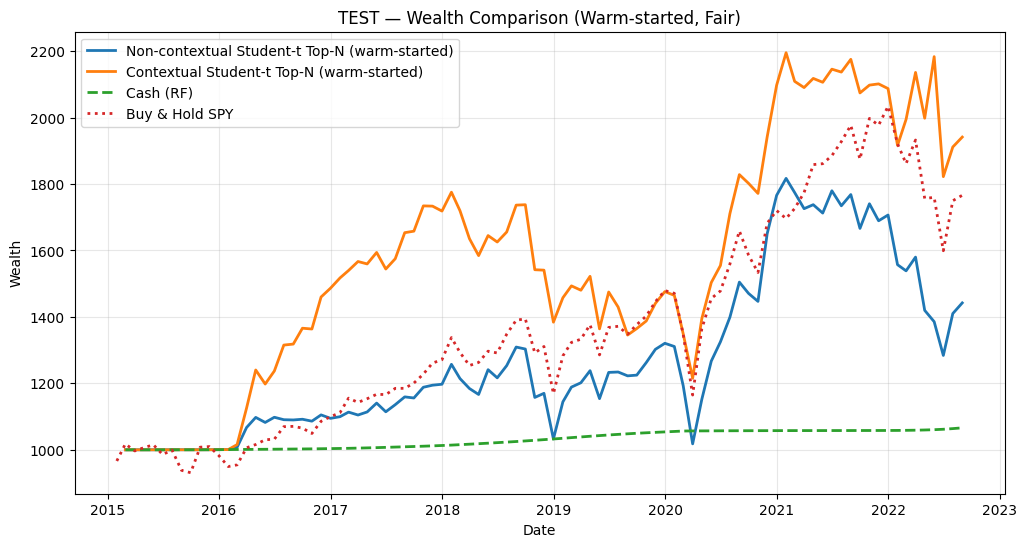

In [48]:
plt.figure(figsize=(12,6))

plt.plot(
    res_nonctx_test_warm["wealth"]["Month_hold"],
    res_nonctx_test_warm["wealth"]["wealth"],
    label="Non-contextual Student-t Top-N (warm-started)",
    linewidth=2
)

plt.plot(
    res_ctx_test["wealth"]["Month_hold"],
    res_ctx_test["wealth"]["wealth"],
    label="Contextual Student-t Top-N (warm-started)",
    linewidth=2
)

plt.plot(
    cash_test["Month_hold"],
    cash_test["wealth"],
    label="Cash (RF)",
    linestyle="--",
    linewidth=2
)

plt.plot(
    spy_test["Month"],
    spy_test["wealth"],
    label="Buy & Hold SPY",
    linestyle=":",
    linewidth=2
)

plt.title("TEST — Wealth Comparison (Warm-started, Fair)")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [30]:
col = MACRO_COLS[0]

check = (
    df.sort_values(MONTH_COL)
      .groupby(ETF_COL)[col]
      .apply(lambda x: x.equals(x.shift(0)))
)

check.unique()

array([ True])

In [31]:
ctx_w = res_ctx_test["wealth"][["Month_hold", "wealth"]].rename(
    columns={"wealth": "wealth_ctx"}
)

spy_w = spy_test.rename(
    columns={"Month": "Month_hold", "wealth": "wealth_spy"}
)

perf_df = (
    ctx_w.merge(spy_w, on="Month_hold", how="inner")
    .sort_values("Month_hold")
)

perf_df["pct_outperformance_vs_spy"] = (
    perf_df["wealth_ctx"] / perf_df["wealth_spy"] - 1.0
)

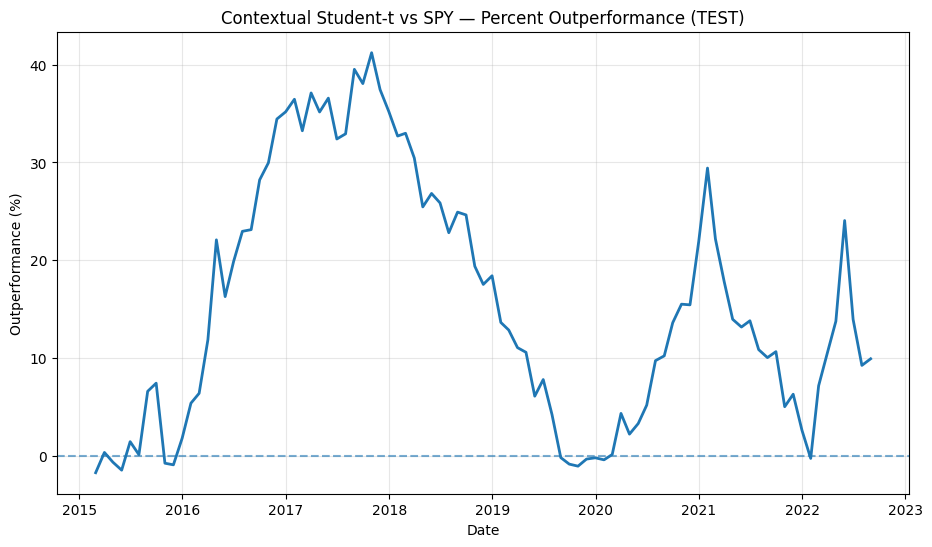

In [32]:
plt.figure(figsize=(11,6))

plt.plot(
    perf_df["Month_hold"],
    100 * perf_df["pct_outperformance_vs_spy"],
    linewidth=2
)

plt.axhline(0.0, linestyle="--", alpha=0.6)
plt.title("Contextual Student-t vs SPY — Percent Outperformance (TEST)")
plt.xlabel("Date")
plt.ylabel("Outperformance (%)")
plt.grid(alpha=0.3)
plt.show()

In [33]:
def etf_holding_counts(weights_df):
    """
    Count number of months each ETF had positive weight.
    """
    df_pos = weights_df.copy()
    df_pos = df_pos[
        (df_pos["ETF"] != "CASH") & (df_pos["weight"] > 0)
    ]

    counts = (
        df_pos.groupby("ETF")["Month_hold"]
        .nunique()
        .sort_values(ascending=False)
    )
    return counts

In [34]:
ctx_counts = etf_holding_counts(res_ctx_test["weights"])

ctx_counts.head(15)

,Month_hold
ETF,
QLD,29
ARKG,20
SMH,17
FTXL,16
SLX,16
SOXX,15
KURE,15
FTXN,13
REMX,11


In [49]:
nonctx_counts = etf_holding_counts(res_nonctx_test_warm["weights"])

compare_holdings = pd.DataFrame({
    "Contextual_months_held": ctx_counts,
    "Non_contextual_months_held": nonctx_counts
}).fillna(0).astype(int)

compare_holdings.sort_values(
    "Contextual_months_held",
    ascending=False
).head(15)

,Contextual_months_held,Non_contextual_months_held
ETF,,
QLD,29,64
ARKG,20,22
SMH,17,0
FTXL,16,18
SLX,16,0
KURE,15,3
SOXX,15,0
FTXN,13,1
REMX,11,0


In [50]:
ctx_w = res_ctx_test["wealth"][["Month_hold", "wealth"]].rename(columns={"wealth": "wealth_ctx"})
spy_w = spy_test.rename(columns={"Month": "Month_hold", "wealth": "wealth_spy"})

ret_df = (
    ctx_w.merge(spy_w, on="Month_hold", how="inner")
        .sort_values("Month_hold")
        .reset_index(drop=True)
)

# Monthly returns from wealth
ret_df["r_ctx"] = ret_df["wealth_ctx"].pct_change()
ret_df["r_spy"] = ret_df["wealth_spy"].pct_change()

# Drop first row (NaN returns)
ret_df = ret_df.dropna(subset=["r_ctx", "r_spy"]).reset_index(drop=True)

# Spread
ret_df["r_diff"] = ret_df["r_ctx"] - ret_df["r_spy"]

ret_df.head()

,Month_hold,wealth_ctx,wealth_spy,r_ctx,r_spy,r_diff
0,2015-03-31,1000.041662,996.674487,0.000025,-0.020638,0.020663
1,2015-04-30,1000.058328,1006.670727,0.000017,0.010030,-0.010013
2,2015-05-31,1000.074994,1015.035637,0.000017,0.008309,-0.008293
3,2015-06-30,1000.091660,985.869067,0.000017,-0.028735,0.028751
4,2015-07-31,1000.116659,999.015273,0.000025,0.013335,-0.013310


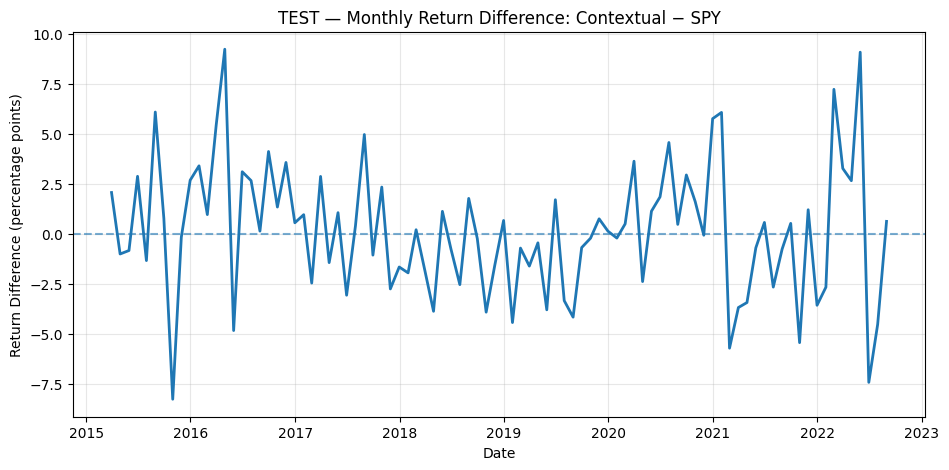

In [52]:
plt.figure(figsize=(11,5))
plt.plot(ret_df["Month_hold"], 100 * ret_df["r_diff"], linewidth=2)

plt.axhline(0.0, linestyle="--", alpha=0.6)
plt.title("TEST — Monthly Return Difference: Contextual − SPY")
plt.xlabel("Date")
plt.ylabel("Return Difference (percentage points)")
plt.grid(alpha=0.3)
plt.show()

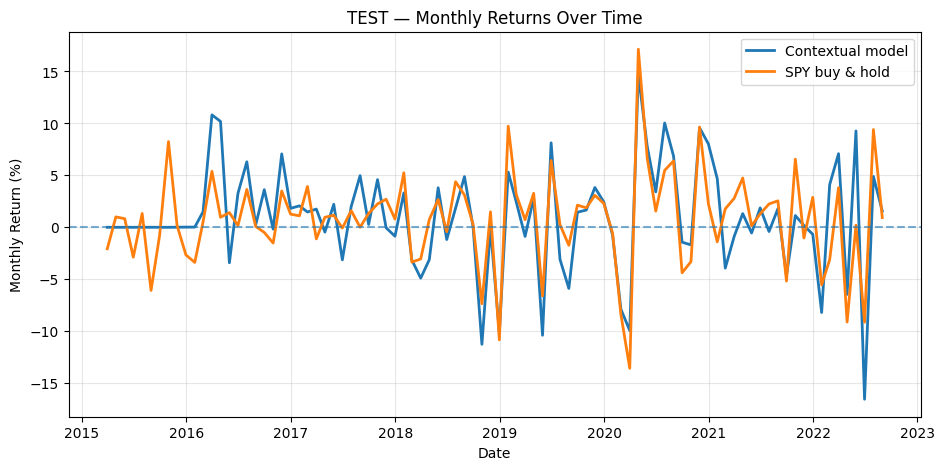

In [53]:
plt.figure(figsize=(11,5))

plt.plot(ret_df["Month_hold"], 100 * ret_df["r_ctx"], label="Contextual model", linewidth=2)
plt.plot(ret_df["Month_hold"], 100 * ret_df["r_spy"], label="SPY buy & hold", linewidth=2)

plt.axhline(0.0, linestyle="--", alpha=0.6)
plt.title("TEST — Monthly Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Monthly Return (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [54]:
print("Mean monthly return (ctx):", ret_df["r_ctx"].mean())
print("Mean monthly return (spy):", ret_df["r_spy"].mean())
print("Mean monthly diff (ctx-spy):", ret_df["r_diff"].mean())
print("Pct of months ctx beats spy:", (ret_df["r_diff"] > 0).mean())

Mean monthly return (ctx): 0.008725768807857455
Mean monthly return (spy): 0.007206567125925042
Mean monthly diff (ctx-spy): 0.0015192016819324126
Pct of months ctx beats spy: 0.5222222222222223


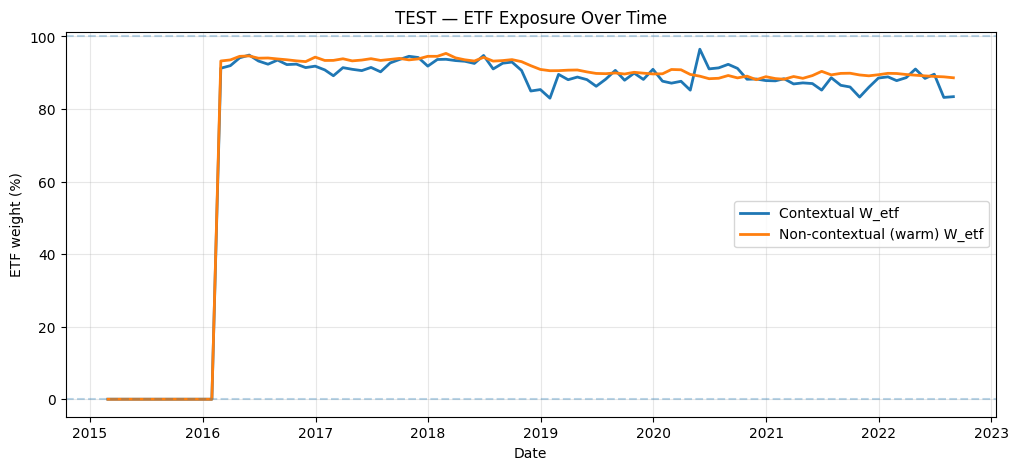

In [57]:
plt.figure(figsize=(12,5))

plt.plot(
    res_ctx_test["wealth"]["Month_hold"],
    100*res_ctx_test["wealth"]["W_etf"],
    linewidth=2,
    label="Contextual W_etf"
)

plt.plot(
    res_nonctx_test_warm["wealth"]["Month_hold"],
    100*res_nonctx_test_warm["wealth"]["W_etf"],
    linewidth=2,
    label="Non-contextual (warm) W_etf"
)

plt.axhline(100, linestyle="--", alpha=0.3)
plt.axhline(0, linestyle="--", alpha=0.3)
plt.title("TEST — ETF Exposure Over Time")
plt.xlabel("Date")
plt.ylabel("ETF weight (%)")
plt.legend()
plt.grid(alpha=0.3)

ONLY FOR CURIOSITY

In [58]:
k_star = k_star  # or set explicitly, e.g. 800
N_star = N_star  # or set explicitly, e.g. 5

# ---- slice window ----
start_date = pd.Timestamp("2005-01-31")
end_date   = pd.Timestamp("2020-12-31")

df_win = df.copy()
df_win[MONTH_COL] = pd.to_datetime(df_win[MONTH_COL])

df_0520 = df_win[(df_win[MONTH_COL] >= start_date) & (df_win[MONTH_COL] <= end_date)].copy()
df_0520 = df_0520.sort_values([MONTH_COL, ETF_COL]).reset_index(drop=True)

print("Window months:", df_0520[MONTH_COL].min(), "->", df_0520[MONTH_COL].max())
print("Unique months:", df_0520[MONTH_COL].nunique(), "Unique ETFs:", df_0520[ETF_COL].nunique())

# ---- standardize macros within this window (no leakage outside the window) ----
Z_COLS = MACRO_COLS  # or your Z_COLS variable

Z_mean_win = df_0520[Z_COLS].mean()
Z_std_win  = df_0520[Z_COLS].std(ddof=0).replace(0.0, 1.0)

df_0520[Z_COLS] = (df_0520[Z_COLS] - Z_mean_win) / Z_std_win

Window months: 2005-01-31 00:00:00 -> 2020-12-31 00:00:00
Unique months: 192 Unique ETFs: 578


In [59]:
res_ctx_0520 = run_policy_simulation_studentt_contextual_topN(
    df_0520, k=k_star, N=N_star, initial_wealth=1000.0
)

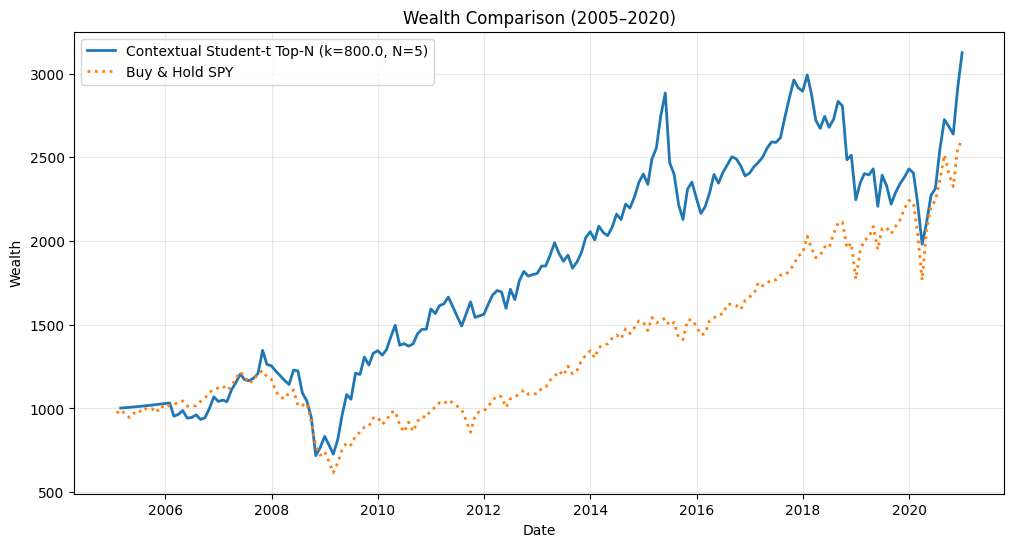

In [63]:
def run_buy_hold_spy_window(df_window, initial_wealth=1000.0):
    spy_df = df_window[df_window[ETF_COL] == "SPY"].sort_values(MONTH_COL).copy()

    wealth = float(initial_wealth)
    out = []
    for _, row in spy_df.iterrows():
        wealth *= (1.0 + float(row[GROWTH_COL]))
        out.append({"Month_hold": row[MONTH_COL], "wealth": wealth})

    return pd.DataFrame(out)

spy_0520 = run_buy_hold_spy_window(df_0520, initial_wealth=1000.0)

plt.figure(figsize=(12,6))

plt.plot(
    res_ctx_0520["wealth"]["Month_hold"],
    res_ctx_0520["wealth"]["wealth"],
    linewidth=2,
    label=f"Contextual Student-t Top-N (k={k_star}, N={N_star})"
)

plt.plot(
    spy_0520["Month_hold"],
    spy_0520["wealth"],
    linewidth=2,
    linestyle=":",
    label="Buy & Hold SPY"
)

plt.title("Wealth Comparison (2005–2020)")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()